## Feedback

1.1 - 2/2

1.2 - 1/2 -> You used 'ivfflat' (inverted file index) instead of 'hnsw' (hierarchical navigable small worlds) to create the index on the embeddings. 

2 -  2/2

3 -  2/2

---
---


# Homework 8.: Vector Databases
## Balázs Menkó (O67UT7)
---

In [1]:
import json
import os
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import psycopg2
import psycopg2.extras

from sqlalchemy import create_engine, Table, Column, Text, LargeBinary, text
from sqlalchemy.orm import sessionmaker, declarative_base
from pgvector.sqlalchemy import Vector

imgs_folder = './imgs'
queries_folder = './queries'

In [2]:
pgsql_settings = {
    'pguser' : 'menkobalazs1',
    'pgpasswd' : 'O67UT7',
    'pghost' : 'postgres-datasci.db-test',
    'pgport' : 5432,
    'pgdb' : 'menkobalazs1_homework',
    'schema' : 'public'
}
def connect_from_settings(settings):
    return psycopg2.connect(
        host = settings['pghost'],
        port = settings['pgport'],
        database = settings['pgdb'],
        user = settings['pguser'],
        password = settings['pgpasswd'],
        options=f'--search_path={settings["schema"]}'
    )

def run_query(query):
    "Run a query in one line"
    connection = connect_from_settings(pgsql_settings)
    cursor = connection.cursor(cursor_factory = psycopg2.extras.DictCursor)
    cursor.execute(query)
    dict_res = cursor.fetchall()
    df = pd.DataFrame(dict_res,columns=list(dict_res[0].keys())) 
    # Close everything
    cursor.close()
    connection.close()
    return df

def get_engine(user, passwd, host, port, db, schema):
    """
    Get SQLalchemy engine using credentials.
    Input:
        db: database name
        user: Username
        host: Hostname of the database server
        port: Port number
        passwd: Password for the database
        schema: Database schema
    Returns:
        Database engine
    """
    url = 'postgresql://{user}:{passwd}@{host}:{port}/{db}'.format(
        user=user, passwd=passwd, host=host, port=port, db=db)
    engine = create_engine(url,connect_args={'options' : f'--search_path={schema}'}, pool_size=50, echo=False)
    return engine


def get_engine_from_settings(settings):
    """
    Sets up database connection from local settings.
    Input:
        settings: Dictionary containing pghost, pguser, pgpassword, pgdatabase, pgport and schema.
    Returns:
        Call to get_database returning engine
    """
    keys = ['pguser','pgpasswd','pghost','pgport','pgdb','schema']
    if not all(key in keys for key in settings.keys()):
        raise Exception('Bad config file')

    return get_engine(settings['pguser'],
                      settings['pgpasswd'],
                      settings['pghost'],
                      settings['pgport'],
                      settings['pgdb'],
                      settings['schema'])

---
# Task 1/a)
Load the image embeddings from ./imgs/imgs_embeddings.json and upload them along with the file name and the (binary) image data into a new table called 'memes_your_username'. (3 points)

* The embedding dimension is 512.
* Make sure to use a unique table name to avoid clashes with the other students. You're all using the public schema, as that's where the pgvector extension is enabled.

```python
with open('imgs/imgs_embeddings.json', 'r') as f:
    imgs = json.load(f) 

connection = connect_from_settings(pgsql_settings)
cursor = connection.cursor()
cursor.execute("""
    CREATE TABLE IF NOT EXISTS memes_menkobalazs1(
        file_id INT PRIMARY KEY,
        filename VARCHAR(255),
        img_embedding VECTOR(512),
        img_data BYTEA
    );
""")
connection.commit()
cursor.close()
connection.close()

data = []
for key, embedding in imgs.items():
    file_id = int(key.split('.')[0])
    filename = key
    file_path = os.path.join(imgs_folder, filename)
    with open(file_path, 'rb') as img_file:
        img_data = img_file.read()
    
    data.append((file_id, filename, embedding, img_data))


connection = connect_from_settings(pgsql_settings)
cursor = connection.cursor()
cursor.executemany("""
    INSERT INTO memes_menkobalazs1 (file_id, filename, img_embedding, img_data)
    VALUES (%s, %s, %s, %s)
    ON CONFLICT (file_id) DO NOTHING;
""", data)
connection.commit()
cursor.close()
connection.close()
```

In [3]:
run_query("""
    SELECT *
    FROM memes_menkobalazs1
""")

,file_id,filename,img_embedding,img_data,img_vector
0,9,9.jpg,"[-0.4478481,-0.7538346,-0.45672616,0.028692424...","[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...","[-0.4478481,-0.7538346,-0.45672616,0.028692424..."
1,3,3.jpg,"[-0.18012482,-1.0258162,-0.17343676,0.07852937...","[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...","[-0.18012482,-1.0258162,-0.17343676,0.07852937..."
2,8,8.jpg,"[-1.1166682,-0.73584044,0.10987082,-0.12467277...","[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...","[-1.1166682,-0.73584044,0.10987082,-0.12467277..."
3,5,5.jpg,"[-0.233625,-1.0150115,0.07597667,0.48650444,-0...","[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...","[-0.233625,-1.0150115,0.07597667,0.48650444,-0..."
4,0,0.jpg,"[-0.23149405,-0.18585905,-0.3253984,0.2935439,...","[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...","[-0.23149405,-0.18585905,-0.3253984,0.2935439,..."
5,6,6.jpg,"[-0.22589162,-0.7036315,0.1266661,0.029228881,...","[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...","[-0.22589162,-0.7036315,0.1266661,0.029228881,..."
6,7,7.jpg,"[-0.62658423,-1.1184272,-0.286002,0.3263272,-0...","[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...","[-0.62658423,-1.1184272,-0.286002,0.3263272,-0..."
7,4,4.jpg,"[-0.2576434,-0.86075306,-0.09094404,-0.0540702...","[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...","[-0.2576434,-0.86075306,-0.09094404,-0.0540702..."
8,1,1.jpg,"[-0.1974415,-0.57443476,0.070811674,0.24392664...","[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...","[-0.1974415,-0.57443476,0.070811674,0.24392664..."
9,2,2.jpg,"[-0.36595595,-0.8268105,-0.5404306,0.15804517,...","[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...","[-0.36595595,-0.8268105,-0.5404306,0.15804517,..."


---
# Task 1/b)
Create a [HNSW index](https://www.pinecone.io/learn/series/faiss/hnsw/) on the 'memes' table with cosine similarity! (1 point)

```python
connection = connect_from_settings(pgsql_settings)
cursor = connection.cursor()
cursor.execute("""
    ALTER TABLE memes_menkobalazs1 ADD COLUMN img_vector vector(512);
""")
cursor.execute("""
    UPDATE memes_menkobalazs1
    SET img_vector = img_embedding::vector;
""")
cursor.execute("""
    CREATE INDEX hnsw_idx 
    ON memes_menkobalazs1
    USING ivfflat (img_vector vector_cosine_ops);
""")
connection.commit()
cursor.close()
connection.close()
```

In [4]:
run_query("""
    SELECT *
    FROM pg_indexes
    WHERE tablename = 'memes_menkobalazs1';
""")

,schemaname,tablename,indexname,tablespace,indexdef
0,public,memes_menkobalazs1,memes_menkobalazs1_pkey,None,CREATE UNIQUE INDEX memes_menkobalazs1_pkey ON...
1,public,memes_menkobalazs1,hnsw_idx,None,CREATE INDEX hnsw_idx ON public.memes_menkobal...


---
# Task 2
Using the embeddings for the query images in './queries/queries_embeddings.json' find the most similar image to each in the database and plot them side-by-side. (3 points)

**Fetch the (binary) image data from the 'memes' table! Do NOT use the local version!**

**Make sure that you write PARAMETRIZED queries!**

In [5]:
with open('./queries/queries_embeddings.json', 'r') as f:
    query_embeddings = json.load(f)

In [6]:
def get_most_similar_image(query_embedding):
    connection = connect_from_settings(pgsql_settings)
    cursor = connection.cursor(cursor_factory=psycopg2.extras.DictCursor)
    query_embedding_vector = f"[{','.join(map(str, query_embedding))}]"
    cursor.execute("""
        SELECT file_id, filename, img_data, img_embedding,
               (1 - (img_embedding <=> %s::vector)) AS similarity
        FROM memes_menkobalazs1
        ORDER BY similarity DESC
        LIMIT 1;
    """, (query_embedding_vector,))
    result = cursor.fetchone()
    cursor.close()
    connection.close()
    return result

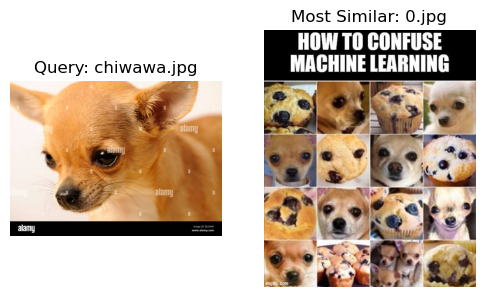

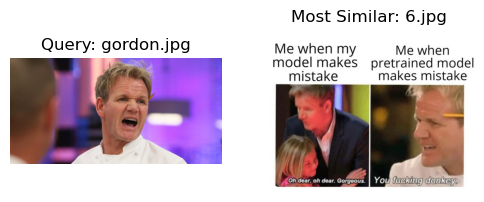

In [7]:
for filename, query_embedding in query_embeddings.items():
    similar_image = get_most_similar_image(query_embedding)
    query_img_path = os.path.join(queries_folder, filename)
    query_img = Image.open(query_img_path)
    similar_img_data = similar_image['img_data']
    similar_img = Image.open(io.BytesIO(similar_img_data))

    plt.figure(figsize=(6, 6))  
    plt.subplot(1, 2, 1)  
    plt.imshow(query_img)
    plt.title(f"Query: {filename}")
    plt.axis('off')
    plt.subplot(1, 2, 2)  
    plt.imshow(similar_img)
    plt.title(f"Most Similar: {similar_image['filename']}")
    plt.axis('off')
    plt.show()  

---
# Task 3
Using the embedding correponding to the text prompt 'An astronaut holding a gun', stored in './queries/text_embeddings.json', find and plot the image in the 'memes' table that is the most similar to it! (3 points)

**Fetch the (binary) image data from the 'memes' table! Do NOT use the local version!**

**Make sure that you write PARAMETRIZED queries!**

In [8]:
with open('./queries/text_embeddings.json', 'r') as f:
    text_embedding = json.load(f)['An astronaut holding a gun.']

In [9]:
def get_most_similar_image_to_text(query_embedding):
    connection = connect_from_settings(pgsql_settings)
    cursor = connection.cursor(cursor_factory=psycopg2.extras.DictCursor)
    query_embedding_vector = f"[{','.join(map(str, query_embedding))}]"
    cursor.execute("""
        SELECT file_id, filename, img_data, img_embedding,
               (1 - (img_embedding <=> %s::vector)) AS similarity
        FROM memes_menkobalazs1
        ORDER BY similarity DESC
        LIMIT 1;
    """, (query_embedding_vector,))
    result = cursor.fetchone()
    cursor.close()
    connection.close()
    return result

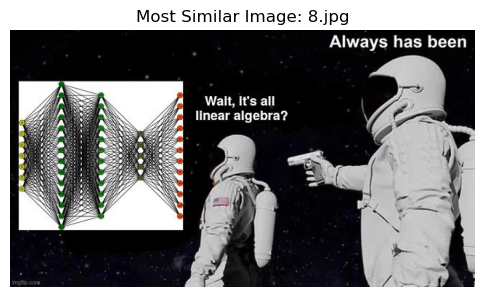

In [10]:
similar_image = get_most_similar_image_to_text(text_embedding)
similar_img_data = similar_image['img_data']
similar_img = Image.open(io.BytesIO(similar_img_data))
plt.figure(figsize=(6, 6))  
plt.imshow(similar_img)
plt.title(f"Most Similar Image: {similar_image['filename']}")
plt.axis('off')
plt.show()